In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")


In [2]:
messages = [
    {"role": "user", "content": """What is Photosynthesis?"""},
]


inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)


In [3]:
num_generations = 3
for _ in range(num_generations):
    outputs = model.generate(**inputs, max_new_tokens=100, do_sample = True, temperature=0.7, top_p = 0.5, top_k=100)
    print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

Photosynthesis! It's the magical process that allows plants to convert sunlight into energy, producing oxygen and glucose in the process. Here's a breakdown of what it's all about:

**What is Photosynthesis?**

Photosynthesis is a natural process that occurs in plants, algae, and some bacteria. It's a complex series of chemical reactions that convert light energy from the sun into chemical energy in the form of glucose (a type of sugar). This process is essential for life on Earth
Photosynthesis! It's the magical process that makes life on Earth possible. Photosynthesis is the way plants, algae, and some bacteria convert light energy from the sun into chemical energy in the form of organic compounds, such as glucose. This process is essential for life, as it provides the energy and organic compounds necessary for the growth and sustenance of most living organisms.

Here's a simplified overview of the photosynthesis process:

**Light-Dependent Reactions (Light Reactions)**

1.
Photosynt

In [4]:
inputs = tokenizer("User: What is Nuclear Fusion?", padding=True, truncation=True, return_tensors = "pt")

outputs = model.generate(**inputs, max_new_tokens=100, do_sample = True, temperature=0.7, top_p = 0.5, top_k=100)
print(tokenizer.decode(outputs[0][:]))

User: What is Nuclear Fusion?<|im_end|>


In [12]:
# load a small reward model (score single Q+A)
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
model_name = "OpenAssistant/reward-model-deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
rm = AutoModelForSequenceClassification.from_pretrained(model_name)  # ~738MB file

question = "Explain nuclear fusion like I'm five."
answer  = "Nuclear fusion is when atoms are fused together and release lots of energy. Hydrogen is used here as fuel."

inputs = tokenizer(question, answer, return_tensors="pt", truncation=True)
logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
score = logits.item()
print("RM score:", score)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RM score: 1.6617525815963745


In [4]:
questions = ["What is photosynthesis?", "What is photosynthesis?", "Who is the president of Mars?", "Who is the president of Mars?"]
answers  = [
    "Photosynthesis is the process by which animals, fishes, and some birds convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. ",
    "Photosynthesis is the process by which plants, algae, and some bacteria convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. ", 
    "The president of Mars is none other than Elon Musk, Tesla CEO", 
    "The President of mars is not a real thing, its a fictional reference from the StarWars movie"

]

inputs = tokenizer(questions, answers, return_tensors="pt", truncation=True, padding=True)
logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
print("RM score:", logits)

RM score: tensor([ 0.5651,  3.0007,  2.9940, -2.5534], grad_fn=<SqueezeBackward0>)


In [5]:
rm.named_modules

<bound method Module.named_modules of DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=

# For Correct Answers 

['Nuclear fusion is when atoms are fused together and release lots of energy', ' Hydrogen is used here as fuel', '']


Processing:: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


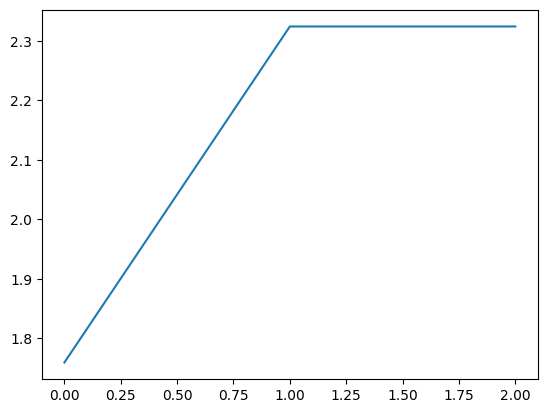

 Nuclear fusion is when atoms are fused together and release lots of energy  Hydrogen is used here as fuel 


In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
question = "Explain nuclear fusion like I'm five."
answer  = "Nuclear fusion is when atoms are fused together and release lots of energy. Hydrogen is used here as fuel."
answers = answer.split(".")

print(answers)

context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(steps, scores)
plt.show()
print(context)

['Photosynthesis is the process by which plants, algae, and some bacteria convert light energy into chemical energy, producing sugars (food) and oxygen', " It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen", '']


Processing:: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


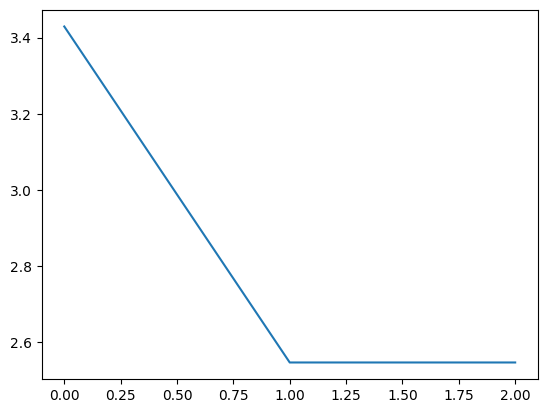

 Photosynthesis is the process by which plants, algae, and some bacteria convert light energy into chemical energy, producing sugars (food) and oxygen  It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen 


In [16]:
question = "what is Photosynthesis?"
answer  = "Photosynthesis is the process by which plants, algae, and some bacteria convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen."
answers = answer.split(".")

print(answers)

context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(steps, scores)
plt.show()
print(context)

In [12]:
context

" Photosynthesis is the process by which plants  algae  and some bacteria convert light energy into chemical energy  producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen."

# For Wrong Answers

In [13]:
question = "Explain nuclear fusion like I'm five."
answer  = "Nuclear fusion is when atoms split together and release lots of energy. An uncontrolled on with Markov K greater will result in explosion"
answers = answer.split(".")

['Nuclear fusion is when atoms split together and release lots of energy', ' An uncontrolled on with Markov K greater will result in explosion']


Processing:: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


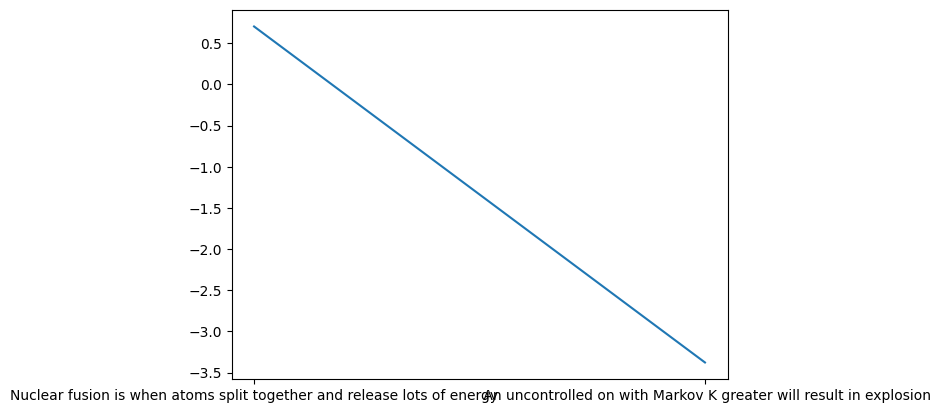

 Nuclear fusion is when atoms split together and release lots of energy  An uncontrolled on with Markov K greater will result in explosion


In [14]:

print(answers)
context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(answers, scores)
plt.show()
print(context)

['Photosynthesis is the process by which animals', ' fishes', ' and some birds convert light energy into chemical energy', " producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. "]


Processing:: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


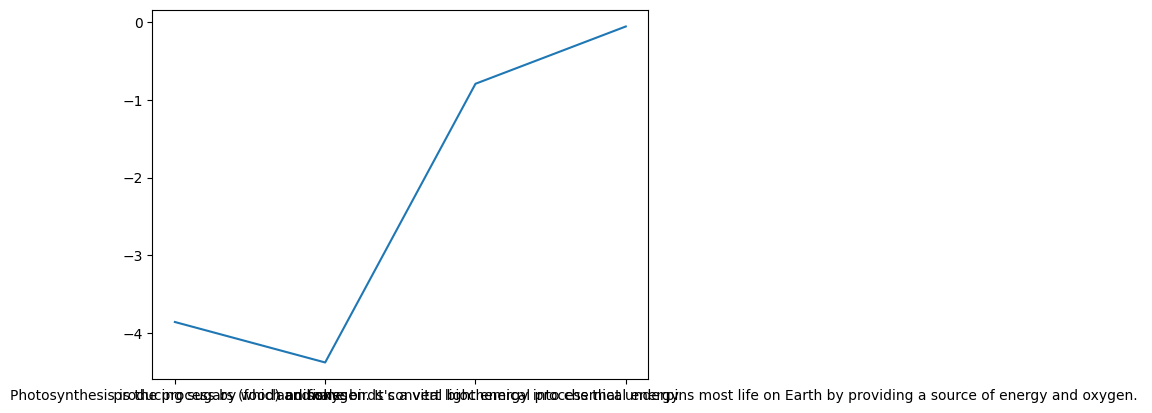

 Photosynthesis is the process by which animals  fishes  and some birds convert light energy into chemical energy  producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. 


In [15]:
question = "what is Photosynthesis?"
answer  = "Photosynthesis is the process by which animals, fishes, and some birds convert light energy into chemical energy, producing sugars (food) and oxygen. It's a vital biochemical process that underpins most life on Earth by providing a source of energy and oxygen. "
answers = answer.split(",")

print(answers)

context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(answers, scores)
plt.show()
print(context)

['Photosynthesis is a chemical process that occurs in plants, algae, some bacteria, and even some fungi', " It's a way for these organisms to convert light energy from the sun into chemical energy in a form of glucose (a type of sugar)", '\n\n**The main steps of photosynthesis:**\n\n1', ' **Light absorption**: Plants use light energy from the sun to kick-start the photosynthesis process', ' They absorb light energy through their leaves, which contains tiny sacs called chloroplasts', '\n2', ' **Light-dependent reaction**: The absorbed light energy is then converted into a molecule called adenosine triphosphate (ATP), which provides the energy for the reaction', ' This step is called the light-dependent reaction', '\n3', ' **Calvin cycle**: The ATP is then used to convert carbon dioxide (a gas) into a three-carbon molecule called 3-phosphoglycerate (3-PGA)', ' This step is called the Calvin cycle', '\n4', ' **Monocarboxylate transport**: The 3-PGA']


Processing:: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]


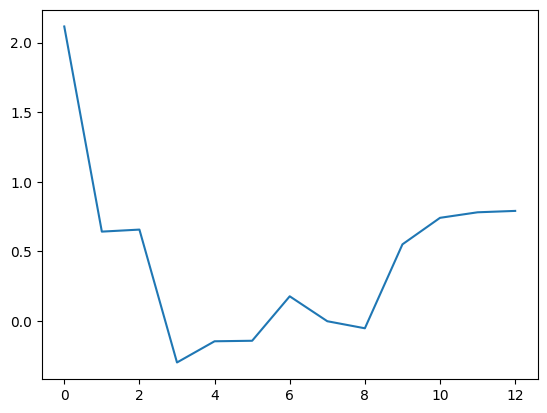

 Photosynthesis is a chemical process that occurs in plants, algae, some bacteria, and even some fungi  It's a way for these organisms to convert light energy from the sun into chemical energy in a form of glucose (a type of sugar) 

**The main steps of photosynthesis:**

1  **Light absorption**: Plants use light energy from the sun to kick-start the photosynthesis process  They absorb light energy through their leaves, which contains tiny sacs called chloroplasts 
2  **Light-dependent reaction**: The absorbed light energy is then converted into a molecule called adenosine triphosphate (ATP), which provides the energy for the reaction  This step is called the light-dependent reaction 
3  **Calvin cycle**: The ATP is then used to convert carbon dioxide (a gas) into a three-carbon molecule called 3-phosphoglycerate (3-PGA)  This step is called the Calvin cycle 
4  **Monocarboxylate transport**: The 3-PGA


In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm

question = "what is Photosynthesis?"
answer  = """Photosynthesis is a chemical process that occurs in plants, algae, some bacteria, and even some fungi. It's a way for these organisms to convert light energy from the sun into chemical energy in a form of glucose (a type of sugar).

**The main steps of photosynthesis:**

1. **Light absorption**: Plants use light energy from the sun to kick-start the photosynthesis process. They absorb light energy through their leaves, which contains tiny sacs called chloroplasts.
2. **Light-dependent reaction**: The absorbed light energy is then converted into a molecule called adenosine triphosphate (ATP), which provides the energy for the reaction. This step is called the light-dependent reaction.
3. **Calvin cycle**: The ATP is then used to convert carbon dioxide (a gas) into a three-carbon molecule called 3-phosphoglycerate (3-PGA). This step is called the Calvin cycle.
4. **Monocarboxylate transport**: The 3-PGA"""
answers = answer.split(".")

print(answers)

context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(steps, scores)
plt.show()
print(context)

['Photosynthesis is the process by which plants, algae, and some bacteria convert light energy from the sun into chemical energy in the form of organic compounds, such as glucose', ' This process is essential for life on Earth, as it provides the energy and organic compounds that are necessary for the growth and survival of plants and many other organisms', '\n\nThe basic steps of photosynthesis are:\n\n1', ' **Light absorption**: Plants absorb energy from sunlight through pigments such as chlorophyll and other accessory pigments', '\n2', ' **Light-dependent reaction**: The energy absorbed is used to split water molecules into hydrogen and oxygen', ' This reaction is known as the light-dependent reaction or one-electron reaction', '\n3', ' **Light-independent reaction**: The hydrogen is used to form glucose through a series of chemical reactions, known as the light-independent reaction or Calvin cycle', '\n4', ' **Production of glucose**: Glucose is produced through the light-independe

Processing:: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


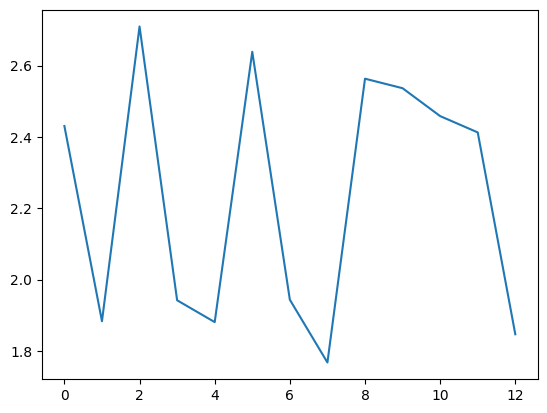

 Photosynthesis is the process by which plants, algae, and some bacteria convert light energy from the sun into chemical energy in the form of organic compounds, such as glucose  This process is essential for life on Earth, as it provides the energy and organic compounds that are necessary for the growth and survival of plants and many other organisms 

The basic steps of photosynthesis are:

1  **Light absorption**: Plants absorb energy from sunlight through pigments such as chlorophyll and other accessory pigments 
2  **Light-dependent reaction**: The energy absorbed is used to split water molecules into hydrogen and oxygen  This reaction is known as the light-dependent reaction or one-electron reaction 
3  **Light-independent reaction**: The hydrogen is used to form glucose through a series of chemical reactions, known as the light-independent reaction or Calvin cycle 
4  **Production of glucose**: Glucose is produced through the light-independent reaction and is used for energy pro

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm

question = "what is Photosynthesis?"
answer  = """Photosynthesis is the process by which plants, algae, and some bacteria convert light energy from the sun into chemical energy in the form of organic compounds, such as glucose. This process is essential for life on Earth, as it provides the energy and organic compounds that are necessary for the growth and survival of plants and many other organisms.

The basic steps of photosynthesis are:

1. **Light absorption**: Plants absorb energy from sunlight through pigments such as chlorophyll and other accessory pigments.
2. **Light-dependent reaction**: The energy absorbed is used to split water molecules into hydrogen and oxygen. This reaction is known as the light-dependent reaction or one-electron reaction.
3. **Light-independent reaction**: The hydrogen is used to form glucose through a series of chemical reactions, known as the light-independent reaction or Calvin cycle.
4. **Production of glucose**: Glucose is produced through the light-independent reaction and is used for energy production, growth, and development. 

The light-dependent reaction occurs in the thylakoid membranes of the chloroplast, which are specialized organelles found in plant cells. The process of reducing the high-energy electrons of the hydrogen atoms to form water molecules is known as the first"""
answers = answer.split(".")

print(answers)

context = ""
scores = []
steps = []
for i in tqdm(range(len(answers)), "Processing:"):
    context += " " + answers[i]
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
        score = logits.item()
    scores.append(score)
    steps.append(i)
    # print("RM score:", score)
    
plt.plot(steps, scores)
plt.show()
print(context)

In [ ]:
import ollama

# out = ollama.generate(model="llama2", prompt="Hello")
# print(out)

prompt = "what is the square root of 16 ?"
resp = ollama.generate(model="llama2", prompt=prompt, system=)
print(resp["response"])


The square root of 16 is 4.


<generator object Client._request.<locals>.inner at 0x000002842F7D0B30>


Processing: 3it [00:02,  1.89it/s]

14


Processing: 449it [02:50,  2.63it/s]



Unfortunately, there is no existing international treaty or agreement that specifically governs the ethical considerations of time travel. While time travel has been a staple of science fiction for decades, it remains purely theoretical at present, and there are many challenges and uncertainties surrounding its potential development and use.

However, if time travel were to become a reality in the future, it is likely that international ethical guidelines would be developed to address the various moral and ethical considerations that could arise from this technology. Some of the issues that might need to be addressed in any such guidelines could include:

1. Temporal tourism: The use of time travel for recreational purposes, such as visiting historical events or meeting famous people from the past or future.
2. Temporal colonialism: The use of time travel to alter the course of historical events or to exploit resources from different time periods.
3. Temporal paradoxes: The potential 

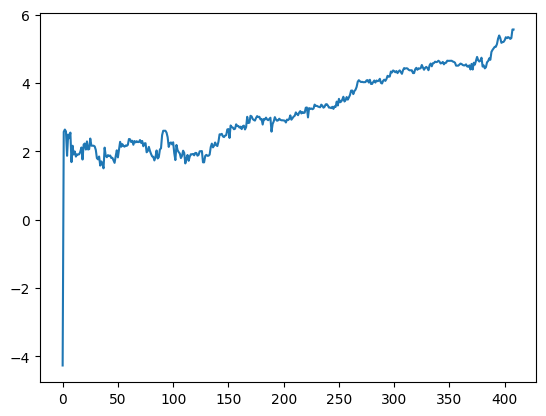

In [32]:
import ollama
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

question = "Describe the international treaty that governs time travel ethics."

stream = ollama.generate(
    model="llama2",
    prompt=question,
    stream=True
)

print(stream)
context = ""
scores = []
steps = []
last_seen = 0
i = 0
for chunk in tqdm(stream, "Processing"):
    # Each chunk contains part of the response
    context += chunk['response']
    # print(chunk['response'], end='')
    if context.find(",", last_seen+1) != -1 or context.find(",", last_seen+1) != -1:
        
        case1 = context.find(",", last_seen+1)
        case2 = context.find(".", last_seen+1)
        
        
        if case1 == -1:
            last_seen = context.find(".", last_seen+1)
            print(last_seen)
        if case2 == -1:
            last_seen = context.find(",", last_seen+1)
            print(last_seen)
            
        inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
        with torch.no_grad():
            logits = rm(**inputs).logits.squeeze()   # scalar score (higher -> more strongly preferred)
            score = logits.item()
        scores.append(score)
        steps.append(i)
        i+=1

plt.plot(steps, scores)
plt.savefig("hallucination_graph_Ollama_llama2.png")
# plt.show()
print(context)

In [30]:
scores

[-1.6766959428787231,
 -1.2181422710418701,
 1.4535876512527466,
 2.2102627754211426,
 2.121157646179199,
 2.0660383701324463,
 2.1045241355895996,
 1.881116509437561,
 1.8769510984420776,
 1.8945715427398682,
 1.8726325035095215,
 1.6449860334396362,
 1.1220731735229492,
 1.7215359210968018,
 1.3945696353912354,
 1.8932944536209106,
 1.8902099132537842,
 1.767203450202942,
 1.835471272468567,
 1.427726149559021,
 0.82602858543396,
 1.6836239099502563,
 1.5986078977584839,
 1.2912927865982056,
 1.8555561304092407,
 1.6388992071151733,
 2.1301052570343018,
 2.043482542037964,
 2.0046885013580322,
 1.962929606437683,
 1.9664026498794556,
 1.9582573175430298,
 1.8598538637161255,
 2.0221877098083496,
 1.9563759565353394,
 2.1074752807617188,
 2.0923242568969727,
 2.07816743850708,
 2.061438798904419,
 1.1876087188720703,
 1.8292287588119507,
 2.0744924545288086,
 1.8756054639816284,
 2.00616455078125,
 2.0909039974212646,
 1.5445514917373657,
 1.4482791423797607,
 1.5575038194656372,
 1.9

',  and  some  fung i  convert  light  energy  from  the  sun  into  chemical'